In [1]:
#Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [2]:
#Load and display first few lines of data
df = pd.read_csv("wustl-ehms-2020_with_attacks_categories.csv")
df.head()

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Attack Category,Label
0,->,e,10.0.1.172,10.0.1.150,58059,1111,496,186,276914.0,92305.0,...,28.9,0,0,0,0,0,0,0.0,normal,0
1,->,e,10.0.1.172,10.0.1.150,58062,1111,496,186,230984.0,76995.0,...,28.9,0,0,0,0,78,17,0.4,normal,0
2,->,e,10.0.1.172,10.0.1.150,58065,1111,496,186,218470.0,72823.0,...,28.9,89,104,0,0,78,17,0.4,normal,0
3,->,e,10.0.1.172,10.0.1.150,58067,1111,496,186,203376.0,67792.0,...,28.9,89,104,0,0,79,17,0.4,normal,0
4,->,e,10.0.1.172,10.0.1.150,58069,1111,496,186,235723.0,78574.0,...,28.9,89,101,0,0,79,17,0.4,normal,0


In [3]:
#Cleaning dataset
#Drop unwanted columns
df = df.drop(columns=['Dir', 'SrcAddr', 'DstAddr', 'Sport','Dport', 'SrcBytes', 
                'DstBytes', 'SrcGap', 'DstGap','SIntPktAct', 'DIntPktAct', 
                'SrcMac', 'DstMac','Packet_num', 'TotPkts', 'TotBytes', 'Loss', 
                'pLoss','pSrcLoss', 'pDstLoss', 'Trans', 'sMaxPktSz', 'dMaxPktSz',
                'sMinPktSz', 'dMinPktSz', 'Label'])

df.head()

,Flgs,SrcLoad,DstLoad,SIntPkt,DIntPkt,SrcJitter,DstJitter,Dur,Load,Rate,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Attack Category
0,e,276914.0,92305.0,3.582333,1.9015,2.946239,1.6235,0.010747,369219.0,558.295,28.9,0,0,0,0,0,0,0.0,normal
1,e,230984.0,76995.0,4.294667,2.9015,3.091654,2.8625,0.012884,307979.0,465.694,28.9,0,0,0,0,78,17,0.4,normal
2,e,218470.0,72823.0,4.540667,3.2945,2.849841,3.1655,0.013622,291293.0,440.464,28.9,89,104,0,0,78,17,0.4,normal
3,e,203376.0,67792.0,4.877667,3.3320,2.452252,3.2570,0.014633,271168.0,410.032,28.9,89,104,0,0,79,17,0.4,normal
4,e,235723.0,78574.0,4.208333,2.8635,3.021835,2.8225,0.012625,314297.0,475.247,28.9,89,101,0,0,79,17,0.4,normal


In [4]:
#Check for null values (no null values)
df.isnull().sum()

Flgs               0
SrcLoad            0
DstLoad            0
SIntPkt            0
DIntPkt            0
SrcJitter          0
DstJitter          0
Dur                0
Load               0
Rate               0
Temp               0
SpO2               0
Pulse_Rate         0
SYS                0
DIA                0
Heart_rate         0
Resp_Rate          0
ST                 0
Attack Category    0
dtype: int64

In [5]:
#Converting all text columns to numerical values + cleaning white-space
df['Flgs'], flgs_labels = pd.factorize(df['Flgs'].str.strip())
print("Flgs mapping:", flgs_labels)

df['Attack Category'], attack_labels = pd.factorize(df['Attack Category'].str.strip())
print("Attack Category mapping:", attack_labels)

df.head()

Flgs mapping: Index(['e', 'M', 'eR', 'M *', 'e s', 'M d', 'MR'], dtype='object')
Attack Category mapping: Index(['normal', 'Data Alteration', 'Spoofing'], dtype='object')


,Flgs,SrcLoad,DstLoad,SIntPkt,DIntPkt,SrcJitter,DstJitter,Dur,Load,Rate,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Attack Category
0,0,276914.0,92305.0,3.582333,1.9015,2.946239,1.6235,0.010747,369219.0,558.295,28.9,0,0,0,0,0,0,0.0,0
1,0,230984.0,76995.0,4.294667,2.9015,3.091654,2.8625,0.012884,307979.0,465.694,28.9,0,0,0,0,78,17,0.4,0
2,0,218470.0,72823.0,4.540667,3.2945,2.849841,3.1655,0.013622,291293.0,440.464,28.9,89,104,0,0,78,17,0.4,0
3,0,203376.0,67792.0,4.877667,3.3320,2.452252,3.2570,0.014633,271168.0,410.032,28.9,89,104,0,0,79,17,0.4,0
4,0,235723.0,78574.0,4.208333,2.8635,3.021835,2.8225,0.012625,314297.0,475.247,28.9,89,101,0,0,79,17,0.4,0


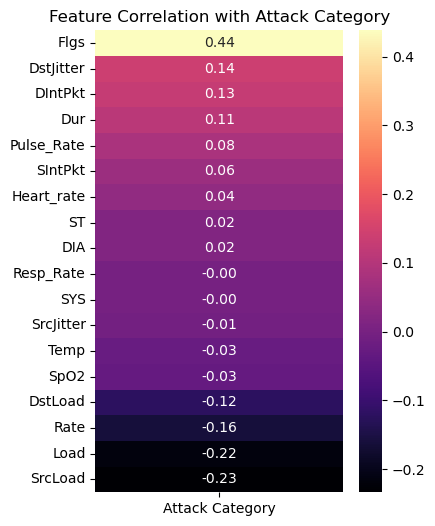

In [6]:
#Correlation heatmap - correlations of features with target feature -> attack category
corr_matrix = df.corr()
target_corr = corr_matrix[['Attack Category']].drop('Attack Category')

plt.figure(figsize=(4, 6))
sns.heatmap(target_corr.sort_values(by='Attack Category', ascending=False),
            annot=True, cmap="magma", fmt=".2f")
plt.title("Feature Correlation with Attack Category")
plt.show()

In [7]:
#Splitting data into training and test sets
X = df.drop('Attack Category', axis = 1)
y = df['Attack Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=14)

In [8]:
#Training a model with random forest
classifier = RandomForestClassifier(class_weight='balanced', random_state=14)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=attack_labels))

                 precision    recall  f1-score   support

         normal       0.94      1.00      0.97      2855
Data Alteration       1.00      0.99      1.00       184
       Spoofing       0.91      0.18      0.30       225

       accuracy                           0.94      3264
      macro avg       0.95      0.72      0.75      3264
   weighted avg       0.94      0.94      0.92      3264



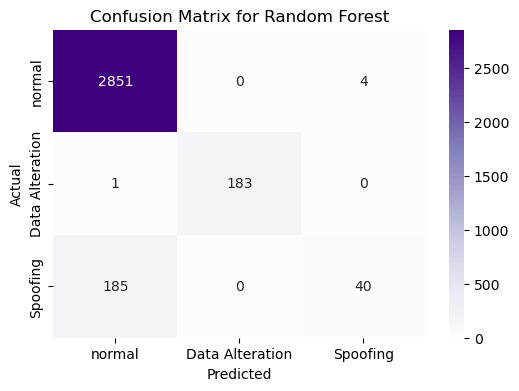

In [9]:
#Creating confusion matrix for Random Forest model
con_matrix = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_matrix, annot=True, fmt='g', xticklabels=attack_labels, yticklabels=attack_labels, cmap='Purples')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

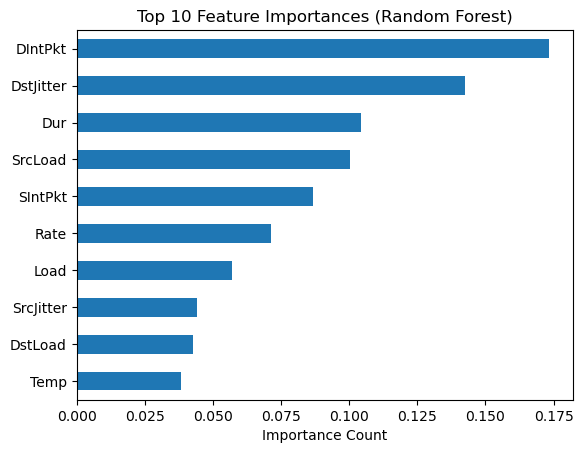

In [10]:
#Creating graph with top 10 most important features used to predict attack categories (Random Forest)
importances = pd.Series(classifier.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Count")
plt.gca().invert_yaxis()
plt.show()

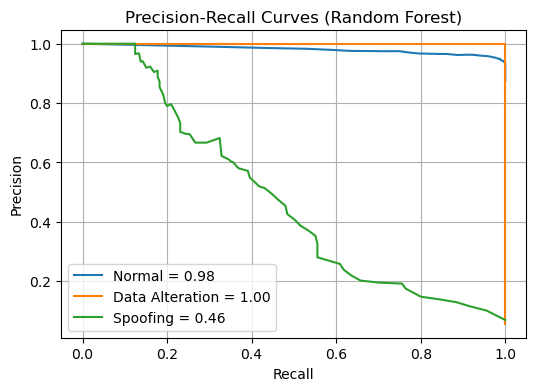

In [11]:
#PR-AUC Curve for each class - Random Forest

# Predicted probabilities
y_prob = classifier.predict_proba(X_test)

#Binary labels
y_true_normal = (y_test == 0)
y_true_data_alt = (y_test == 1)
y_true_spoofing = (y_test == 2)

#Probabilities
prob_normal = y_prob[:, 0]
prob_data_alt = y_prob[:, 1]
prob_spoofing = y_prob[:, 2]

#PR-AUC scores
pr_auc_normal = metrics.average_precision_score(y_true_normal, prob_normal)
pr_auc_data_alt = metrics.average_precision_score(y_true_data_alt, prob_data_alt)
pr_auc_spoofing = metrics.average_precision_score(y_true_spoofing, prob_spoofing)

#Precision-recall curves
prec_normal, rec_normal, _ = metrics.precision_recall_curve(y_true_normal, prob_normal)
prec_data_alt, rec_data_alt, _ = metrics.precision_recall_curve(y_true_data_alt, prob_data_alt)
prec_spoofing, rec_spoofing, _ = metrics.precision_recall_curve(y_true_spoofing, prob_spoofing)

#Plot curves
plt.figure(figsize=(6, 4))
plt.plot(rec_normal, prec_normal, label=f"Normal = {pr_auc_normal:.2f}")
plt.plot(rec_data_alt, prec_data_alt, label=f"Data Alteration = {pr_auc_data_alt:.2f}")
plt.plot(rec_spoofing, prec_spoofing, label=f"Spoofing = {pr_auc_spoofing:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
#Anomaly detection - Isolation Forest
X_normal = X_train[y_train == 0]
iso = IsolationForest(contamination = 0.07, random_state = 14)
iso.fit(X_normal)

#Anomaly scores
X_train['anomaly score'] = iso.decision_function(X_train)
X_test['anomaly score'] = iso.decision_function(X_test)

In [13]:
#Hybrid model - combining Random Forest with anomaly detection (Isolation Forest)
classifier_hybrid = RandomForestClassifier(class_weight='balanced', random_state=14)
classifier_hybrid.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=14)

In [14]:
#Evaluation of hybrid random Forest anomaly detection model (minimal change shown)
y_pred_hybrid = classifier_hybrid.predict(X_test)
print(metrics.classification_report(y_test, y_pred_hybrid, target_names=attack_labels))
print(metrics.confusion_matrix(y_test, y_pred_hybrid))

                 precision    recall  f1-score   support

         normal       0.94      1.00      0.97      2855
Data Alteration       1.00      0.99      1.00       184
       Spoofing       0.93      0.18      0.30       225

       accuracy                           0.94      3264
      macro avg       0.96      0.72      0.75      3264
   weighted avg       0.94      0.94      0.92      3264

[[2852    0    3]
 [   1  183    0]
 [ 185    0   40]]


In [15]:
#Adjusting thresholds for spoofing attacks for initial Random Forest model
spoof_index = 2
spoof_threshold = 0.25
y_pred_thresh = np.argmax(y_prob, axis=1)
y_pred_thresh[y_prob[:, spoof_index] > spoof_threshold] = spoof_index

#Evaluation
print(metrics.classification_report(y_test, y_pred_thresh, target_names=attack_labels))
print(metrics.confusion_matrix(y_test, y_pred_thresh))

                 precision    recall  f1-score   support

         normal       0.96      0.97      0.96      2855
Data Alteration       1.00      0.99      1.00       184
       Spoofing       0.51      0.43      0.47       225

       accuracy                           0.93      3264
      macro avg       0.82      0.80      0.81      3264
   weighted avg       0.93      0.93      0.93      3264

[[2763    0   92]
 [   1  183    0]
 [ 128    0   97]]


In [16]:
#Random Forest with SMOTE oversampling
smote = SMOTE(sampling_strategy='not majority', random_state=14)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Retrain Random Forest
rf_smote = RandomForestClassifier(class_weight='balanced', random_state=14)
rf_smote.fit(X_train_smote, y_train_smote)

#Predict on the original test set
y_pred_rf_smote = rf_smote.predict(X_test)

#Evaluation
print(metrics.classification_report(y_test, y_pred_rf_smote, target_names=attack_labels))
print(metrics.confusion_matrix(y_test, y_pred_rf_smote))

                 precision    recall  f1-score   support

         normal       0.96      0.97      0.96      2855
Data Alteration       1.00      1.00      1.00       184
       Spoofing       0.52      0.45      0.48       225

       accuracy                           0.93      3264
      macro avg       0.82      0.81      0.81      3264
   weighted avg       0.93      0.93      0.93      3264

[[2761    0   94]
 [   0  184    0]
 [ 124    0  101]]


In [17]:
#XGBoost model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=14)
xgb.fit(X_train, y_train)

#Predict and evaluate on the test set
y_pred_xgb = xgb.predict(X_test)

#Evaluation
print(metrics.classification_report(y_test, y_pred_xgb, target_names=attack_labels))

                 precision    recall  f1-score   support

         normal       0.96      1.00      0.98      2855
Data Alteration       1.00      1.00      1.00       184
       Spoofing       0.89      0.43      0.58       225

       accuracy                           0.96      3264
      macro avg       0.95      0.81      0.85      3264
   weighted avg       0.95      0.96      0.95      3264



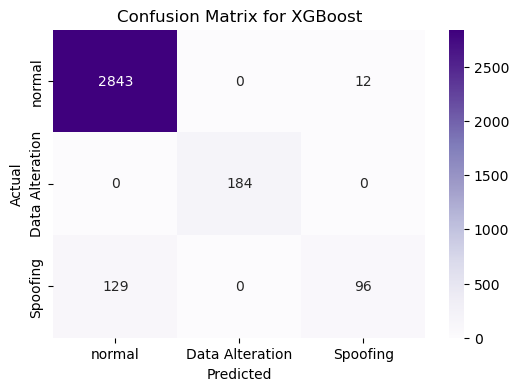

In [18]:
#Creating confusion matrix for XGBoost model
con_matrix_xgb = metrics.confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(con_matrix_xgb, annot=True, fmt='g', xticklabels=attack_labels, yticklabels=attack_labels, cmap='Purples')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost")
plt.show()

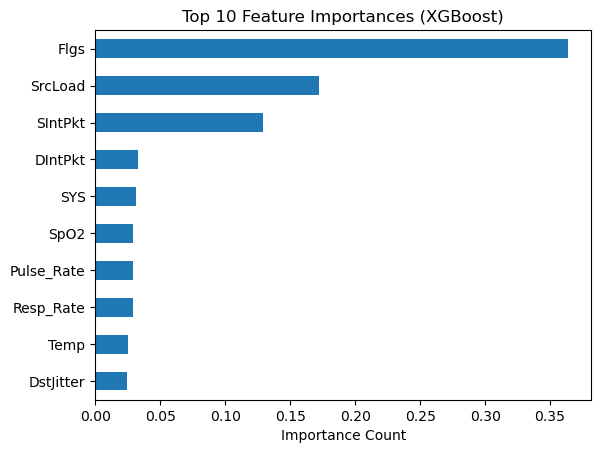

In [19]:
#Creating graph with top 10 most important features used to predict attack categories (XGBoost)
importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance Count")
plt.gca().invert_yaxis()
plt.show()

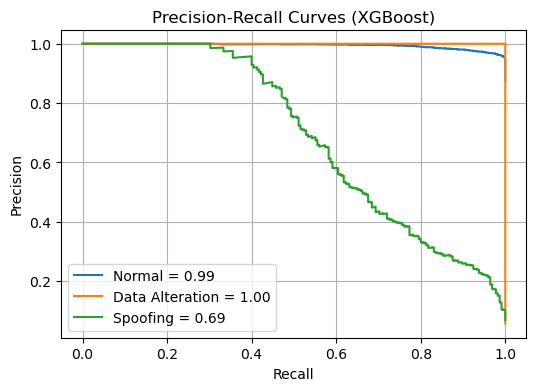

In [20]:
#PR-AUC curve of best performing model: XGBoost

#Predicted probabilities
y_prob_xgb = xgb.predict_proba(X_test)

#Probabilities
prob_normal = y_prob_xgb[:, 0]
prob_data_alt = y_prob_xgb[:, 1]
prob_spoofing = y_prob_xgb[:, 2]

#PR-AUC scores
pr_auc_normal = metrics.average_precision_score(y_true_normal, prob_normal)
pr_auc_data_alt = metrics.average_precision_score(y_true_data_alt, prob_data_alt)
pr_auc_spoofing = metrics.average_precision_score(y_true_spoofing, prob_spoofing)

#Precision-recall curves
prec_normal, rec_normal, _ = metrics.precision_recall_curve(y_true_normal, prob_normal)
prec_data_alt, rec_data_alt, _ = metrics.precision_recall_curve(y_true_data_alt, prob_data_alt)
prec_spoofing, rec_spoofing, _ = metrics.precision_recall_curve(y_true_spoofing, prob_spoofing)

#Plot curves
plt.figure(figsize=(6, 4))
plt.plot(rec_normal, prec_normal, label=f"Normal = {pr_auc_normal:.2f}")
plt.plot(rec_data_alt, prec_data_alt, label=f"Data Alteration = {pr_auc_data_alt:.2f}")
plt.plot(rec_spoofing, prec_spoofing, label=f"Spoofing = {pr_auc_spoofing:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
#Adjusting thresholds for spoofing attacks for XGBoost
spoof_index = 2
spoof_threshold = 0.25
y_pred_thresh_xgb = np.argmax(y_prob_xgb, axis=1)
y_pred_thresh_xgb[y_prob_xgb[:, spoof_index] > spoof_threshold] = spoof_index

#Evaluation
print(metrics.classification_report(y_test, y_pred_thresh_xgb, target_names=attack_labels))
print(metrics.confusion_matrix(y_test, y_pred_thresh_xgb))

                 precision    recall  f1-score   support

         normal       0.97      0.98      0.97      2855
Data Alteration       1.00      1.00      1.00       184
       Spoofing       0.66      0.56      0.60       225

       accuracy                           0.95      3264
      macro avg       0.88      0.84      0.86      3264
   weighted avg       0.95      0.95      0.95      3264

[[2791    0   64]
 [   0  184    0]
 [ 100    0  125]]


In [22]:
#Stratified K-Fold Cross-Validation with XGBoost
xgb = XGBClassifier(eval_metric='mlogloss', random_state=14)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
scores = cross_val_score(xgb, X, y, cv=skf, scoring=metrics.make_scorer(metrics.f1_score, average='macro'))

print("Macro F1-scores:", scores)
print("Mean F1-score:", scores.mean())
print("Standard deviation:", scores.std())

Macro F1-scores: [0.84516424 0.86129129 0.86064757 0.85749231 0.83716909]
Mean F1-score: 0.8523529015807375
Standard deviation: 0.009563837612404806
